# Setting

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [0]:
%ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3174           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23383           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5379            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        388           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1710            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7188   

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 62.2MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 64.7MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.0MB/s]


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# **Data Load**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(len(test))

3263


In [0]:
train.head(40)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


### final_text : concat keyword one hot encoding and target

In [0]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
df.fillna('', inplace=True)

#### Data Cleaning

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [0]:
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### train과 test set에서 URL, html, 구두점을 삭제한다.

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

### Remove Mislabeled
https://www.kaggle.com/rai555/real-or-not-nlp-huggingface-bert-pytorch

## **Model**

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.8MB/s 


#### Encoding

In [0]:
# text -> tokens with padding
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 29.6 s, sys: 5.26 s, total: 34.9 s
Wall time: 45 s


In [0]:
import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_len = len(train)
print(train_len)
train = df[:train_len]
test = df[train_len:]

7613


In [0]:
train.head(10)

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,4,,,Forest fire near La Ronge Sask Canada,1
2,5,,,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1
3,6,,,13000 people receive wildfires evacuation orders in California,1
4,7,,,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1
5,8,,,RockyFire Update California Hwy 20 closed in both directions due to Lake County fire CAfire wildfires,1
6,10,,,flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas,1
7,13,,,Im on top of the hill and I can see a fire in the woods,1
8,14,,,Theres an emergency evacuation happening now in the building across the street,1
9,15,,,Im afraid that the tornado is coming to our area,1


In [0]:
train = train.sample(frac=1).reset_index(drop=True)

In [0]:
train.head(10)

,id,keyword,location,text,target
0,3466,derailed,lee london,The crocodile tears dont wash with me shes more upset that the gravy train has been derailed kidscompany,1
1,4687,engulfed,london,suelinflower there is no words to describe the physical painthey ripped you apart while you screamed for dear lifeits like been engulfed,0
2,7338,nuclear%20reactor,,Finnish ministers Fennovoima nuclear reactor will go ahead,0
3,7888,quarantined,,oc73x mhtw4fnet\n\nOfficials Alabama home quarantined over possible Ebola case Washington Post,1
4,2505,collision,'soooota,Zojadelin you literally almost had a head on collision with us today on pilot knob,1
5,314,annihilated,The Canopy Kingdom,BOOM Your country was just entirely annihilated by a hÛ ÛÓ Britain,0
6,5626,flooding,UK,floods ukfloods British trekkers rescued amid flash floods in Himalayas A group of British tr flooding,1
7,10824,wrecked,"Denton, Texas",Had an awesome time gettin wrecked at bowling last night,0
8,8942,storm,,FINALLY a storm,0
9,5326,fire,,I See Fire,0


In [0]:
from sklearn.preprocessing import OneHotEncoder

def get_key_word_one_hot_encoding(data):
    encoder = OneHotEncoder()
    keywords_encoded, keywords_categories = data['keyword'].factorize()
    keywords_hot = encoder.fit_transform(keywords_encoded.reshape(-1,1))
    encoded = keywords_hot.toarray() # keyword answer
    return encoded

In [0]:
keyword_answers = get_key_word_one_hot_encoding(train)
keyword_answers = np.asarray(keyword_answers, np.float32)
print(keyword_answers.shape)

(7613, 222)


In [0]:
val_len = int(train_len*0.2)
val = train[-val_len:]
train = train[:-val_len]

In [0]:
print(len(val))
print(len(train))

1522
6091


In [0]:
train_keyword_answers = keyword_answers[:-val_len]
val_keyword_answers = keyword_answers[-val_len:]
print(val_keyword_answers.shape)

(1522, 222)


In [0]:
train.head(10)

,id,keyword,location,text,target
0,3466,derailed,lee london,The crocodile tears dont wash with me shes more upset that the gravy train has been derailed kidscompany,1
1,4687,engulfed,london,suelinflower there is no words to describe the physical painthey ripped you apart while you screamed for dear lifeits like been engulfed,0
2,7338,nuclear%20reactor,,Finnish ministers Fennovoima nuclear reactor will go ahead,0
3,7888,quarantined,,oc73x mhtw4fnet\n\nOfficials Alabama home quarantined over possible Ebola case Washington Post,1
4,2505,collision,'soooota,Zojadelin you literally almost had a head on collision with us today on pilot knob,1
5,314,annihilated,The Canopy Kingdom,BOOM Your country was just entirely annihilated by a hÛ ÛÓ Britain,0
6,5626,flooding,UK,floods ukfloods British trekkers rescued amid flash floods in Himalayas A group of British tr flooding,1
7,10824,wrecked,"Denton, Texas",Had an awesome time gettin wrecked at bowling last night,0
8,8942,storm,,FINALLY a storm,0
9,5326,fire,,I See Fire,0


In [0]:
print(train_keyword_answers[0])
print(train_keyword_answers[1])
print(train_keyword_answers[2])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [0]:
train.iloc[148:159]

,id,keyword,location,text,target
148,5400,fire%20truck,"Nevada Carson City,Freeman St",rgj Truck trailer catches fire in Reno,1
149,10726,wreck,,i still dont see the point of a frozen sequel like wheres the wreck it ralph sequel,0
150,8112,rescued,,I liked a YouTube video RomanAtwoodVlogs RESCUED SICK KITTENS,0
151,6832,loud%20bang,Kenya,matako3 Breaking news Unconfirmed I just heard a loud bang nearby in what appears to be a blast of wind from my neighbours ass,0
152,2482,collided,,Stupid women nearly collided into me today after she came out of a junction not looking Still kept coming towards me till I beep my horn,1
153,5459,first%20responders,"Franklin, TN near Nashville",After shooting event at the theater Starbucks is giving FREE COFFEE to all first responders police amp firefighters AntiochHickoryHollowTN,1
154,575,arson,"Miami,FL",RelaxInPR miprv RT latimes Arson suspect linked to 30 fires caught in Northern California,1
155,9458,terrorism,"Lancaster, CA",Still domestic terrorism,1
156,10695,wreck,"Somerset, UK",LARGE SHIP WRECK FISH TANK ORNAMENT FOR SALE LARGE SHIP WRECK FISH TANK AQUA,0
157,9488,terrorism,,Pakistan Supreme Court endorses military courts for terrorism cases,1


In [0]:
print(train_keyword_answers[149])
print(train_keyword_answers[156])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [0]:
train[100:120]

,id,keyword,location,text,target
100,2864,damage,,Its crazy how a phone can do so much damage to a person,0
101,4381,earthquake,,M157 0111 UTC3km NNW of Lake Henshaw California,1
102,9667,tornado,Austin,73rd GOODE Water Ski National Championships will go on as planned next week Event w damage from a tornado on Mon,1
103,6594,inundated,Bristol,Hi FionaGilbert sorry for the delay Slightly inundated with applications at the mo but we have yours and will get back to you asap,0
104,7149,mudslide,"London, Greater London, UK",Stu put beetroot in his cake and even lost to a mudslide,0
105,247,ambulance,Jackson,Twelve feared killed in Pakistani air ambulance helicopter crash,1
106,4830,evacuation,,Run out evacuation hospital indexing remedial of angioplasty dissertation at power elite hospitals dismayedÛ,1
107,8055,refugees,"NYC,US - Cali, Colombia",The Most Generous Bride on Earth Couple Feeds 4000 Syrian Refugees on Their Wedding Day via thedailybeast love it,0
108,8747,siren,New England,Amateur Night Actress Reprises Role for Siren HorrorMoviesca horror,1
109,3090,deaths,london town..,Heard theres two more deaths and a murder chrissie kills adam val and finn die emmerdale,0


In [0]:
val[100:105]

,id,keyword,location,text,target
6191,77,ablaze,Anaheim,Police Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze,1
6192,10299,weapon,,GUN FIREARM WEAPON VECTOR CLIP ART FOR VINYL SIGN CUTTER RIFLE GUNS WEAPONS,0
6193,10471,wild%20fires,,Full Episode WN 080215 California Wild Fires Force 12000 to Evacuate Worldnews,1
6194,4128,drought,Football Field,The Drought Is Real,1
6195,310,annihilated,Boston,Cop pulls drunk driver to safety SECONDS before his car is hit by train via ViralSpell,1


In [0]:
print(val_keyword_answers[106])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [0]:
train_disaster_answers = train['target'].values
train_disaster_answers = np.asarray(train_disaster_answers, np.float32)

val_disaster_answers = val['target'].values
val_disaster_answers = np.asarray(val_disaster_answers, np.float32)

In [0]:
#check
print(train.shape)
print(train_disaster_answers.shape)
print(train_keyword_answers.shape)


print(val.shape)
print(val_disaster_answers.shape)
print(val_keyword_answers.shape)

(6091, 5)
(6091,)
(6091, 222)
(1522, 5)
(1522,)
(1522, 222)


In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
val_input = bert_encode(val.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)

#### Build Model

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    output = tf.keras.layers.Dropout(0.2)(clf_output)

    disaster_out = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="disaster_output")(output)
    keyword_out = Dense(222, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="keyword_output")(output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[disaster_out, keyword_out])
    losses = {
        "disaster_output": "binary_crossentropy",
        "keyword_output": "categorical_crossentropy"
    }
    lossWeights = {
        "disaster_output": 1.0,
        "keyword_output": 1.0 }
    model.compile(optimizer=Adam(lr=2e-6), loss=losses, loss_weights=lossWeights, metrics=['accuracy'])
    
    return model

In [0]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
%%time
train_history = model.fit(
    train_input, 
    {"disaster_output": train_disaster_answers, "keyword_output": train_keyword_answers },
    validation_data=(val_input, {"disaster_output": val_disaster_answers, "keyword_output": val_keyword_answers}),
    epochs=15,
    batch_size=8
)

Epoch 1/15
762/762 [==============================] - 404s 530ms/step - loss: 9.6367 - disaster_output_loss: 0.5308 - keyword_output_loss: 5.4522 - disaster_output_accuracy: 0.7445 - keyword_output_accuracy: 0.0113 - val_loss: 9.3988 - val_disaster_output_loss: 0.4532 - val_keyword_output_loss: 5.3066 - val_disaster_output_accuracy: 0.8062 - val_keyword_output_accuracy: 0.0388
Epoch 2/15
762/762 [==============================] - 401s 526ms/step - loss: 9.3363 - disaster_output_loss: 0.4346 - keyword_output_loss: 5.2737 - disaster_output_accuracy: 0.8061 - keyword_output_accuracy: 0.0458 - val_loss: 9.1079 - val_disaster_output_loss: 0.4199 - val_keyword_output_loss: 5.0693 - val_disaster_output_accuracy: 0.8239 - val_keyword_output_accuracy: 0.0854
Epoch 3/15
762/762 [==============================] - 401s 526ms/step - loss: 8.6230 - disaster_output_loss: 0.3852 - keyword_output_loss: 4.6276 - disaster_output_accuracy: 0.8348 - keyword_output_accuracy: 0.1410 - val_loss: 8.3467 - val_

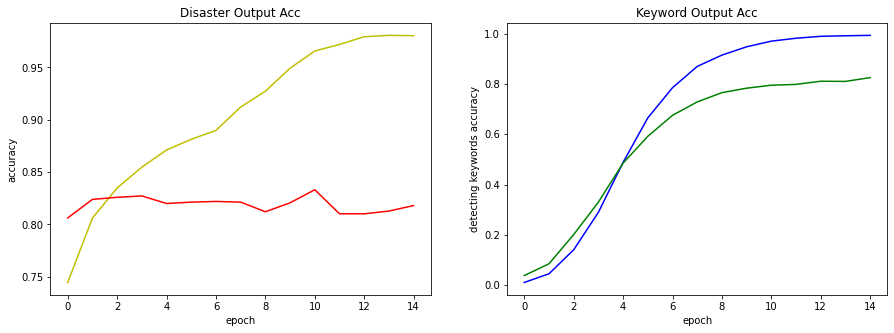

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(train_history.history['disaster_output_accuracy'], 'y', label='train accuracy')
ax1.plot(train_history.history['val_disaster_output_accuracy'], 'r', label='val accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.title.set_text("Disaster Output Acc")

ax2.plot(train_history.history['keyword_output_accuracy'], 'b', label='detecting keywords accuracy')
ax2.plot(train_history.history['val_keyword_output_accuracy'], 'g', label='val detecting keywords accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('detecting keywords accuracy')
ax2.title.set_text("Keyword Output Acc")

plt.show()

In [0]:
model.save('Bertmode.h5')

In [0]:
cp './Bertmodel.h5' '/content/gdrive/My Drive/Data Mining Project/BertmodelwKeyword3.h5'

cp: cannot stat './Bertmodel.h5': No such file or directory


## Submission

In [0]:
submission=pd.read_csv('./sample_submission.csv')

In [0]:
test_pred, _ = model.predict(test_input)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('Bert+keyword2_submission.csv', index=False)

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
!cp './Bert+keyword_submission.csv' '/content/gdrive/My Drive/Data Mining Project/Bert+keyword2_submission.csv'

cp: cannot stat './Bert+keyword_submission.csv': No such file or directory


In [0]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
